# 0. Imports packages, modules and functions

## 0.1. Import modules

In [39]:
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt

from IPython.display            import Image
from IPython.display            import HTML
from scipy                      import stats
from boruta                     import BorutaPy
from imblearn.combine           import SMOTETomek
from sklearn                    import cluster
from sklearn.ensemble           import RandomForestRegressor
from sklearn.ensemble           import RandomForestClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.model_selection    import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import RobustScaler, MinMaxScaler
from sklearn.preprocessing      import OneHotEncoder
from yellowbrick.cluster        import KElbowVisualizer

from xgboost import XGBClassifier

import datetime
import inflection
import math
import pickle
import random
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## 0.2. Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

def get_class_count(df, identification, target_var):
    
    class_count = df.groupby([target_var])[identification].nunique()
    return {key: class_count[key] for key in list(class_count.keys())}

def get_class_proportion(df, identification, target_var):
    
    class_counts = get_class_count(df, identification , target_var)
    return {val[0]: round(100 * val[1]/df.shape[0], 2) for val in class_counts.items()}

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

## 0.3. Loading data

In [3]:
 # load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding = "ISO-8859-1" )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

## 0.4. Image controls

In [4]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Data description

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [16]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.2. Data dimensions

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


The dataset consist of more than 500,000 items purchases with different purchases must refer to the same purchase order and customer, while it has only 8 columns.

## 1.3. Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

The types of the invoice number, customer id and invoice date seem to have the wrong type. Customer ID and invoice number should be represented by the int number type, while the invoice date should be represented by a datetime.

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [10]:
df1 = df1.dropna(subset=['description', 'customer_id'])

print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

Removed data: 24.93%


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

The data has many problems with NA purchase orders, that may be represented by some business problem or relevant information, such as reversed logistics to product change or devolution. It can be represented by both the negative quantities and the letters whitin the invoice number. All those data will be removed from the dataset.

## 1.6. Change dtypes

In [16]:
 # invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

Even after the removal of NA values, it was not possible to remove all invoice numbers with a letter in it. So, it was not possible to change the invoice number type. Maybe it could be necessary to create features that properly represents the business problem behind the reason of a letter to appear in it. 

## 1.7. Descriptive statistics

It is intended to solve the clusterization problem with the RFM model, the descriptive statistics will be analyzed after the creation of the variables necessary to create the model.

# 2. Feature engineering

In [21]:
df2 = df1.copy()

## 2.1. Feature creation

The features will be created in order to adjust the clusterization problem with a RFM model solution. For this, the main features within the model will be the monetary, frequency and recency. The monetary consists of the total amount of revenue from a given client, the frequency measures how many different purchases the client has made, while the recency measures the difference between the actual date (highest date within the dataset) and the last purchase date.

In [76]:
 # data reference
df_ref = df2.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates().reset_index(drop=True)

df_ref.head()

,customer_id,gross_revenue
0,17850,15.30
1,17850,20.34
2,17850,22.00
3,17850,15.30
4,17850,25.50


In [77]:
# Gross Revenue = quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )


In [78]:
# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue_x,gross_revenue_y,recency_days,invoice_no
0,17850,15.30,5288.63,302,35
1,17850,20.34,5288.63,302,35
2,17850,22.00,5288.63,302,35
3,17850,15.30,5288.63,302,35
4,17850,25.50,5288.63,302,35


# 3. Variable filtering

In [79]:
df3 = df_ref.copy()

# 4. Exploratory data analysis

In [80]:
df4 = df3.copy()

# 5. Data preparation

# 6. Feature selection

In [81]:
df6 = df4.copy()

# 7. Hyperparameter fine tuning

There are 3 types of major problems within data problems to solve with machine learning algorithms: regression, classification and clusterization. The first two problems, regression and classification, there is a necessity to split the dataset between training and testing and there is a target variable to analyze the accuracy and precision of the model, while the clusterization problems does not have the need in dataset spliting. Because of that, there is a necessity to first determine the number of clusters which the dataset will be split, before training and finding the model.

In [82]:
df7 = df6.copy()

In [83]:
X = df7.drop(columns=['customer_id'])

## 7.1. Cluster evaluation metrics

Clustering problems in data science do not have a target variable, which means that the clustering error and precision depends on the analyst's input. In order to reduce the subjectiviy of the analyst's choice, there are some metrics to evaluate how many cluster the datset must be divided. Two metrics are the within-cluster sum of square (WSS) or the sillhouette score.

The WSS metric measures the compactness of a cluster, which means that for a given point within a cluster, the distances of each point inside that cluster must be minimal, while the distance of the points to the nearest cluster should be maximum. However, the WSS does not measure the distances between the clusters. This is a problem, since we could have 2 extremely compact cluster with overlap and the WSS metric would result in great clusterization. 


To solve this problem, we can use the silhouette score, which measures the both the separation of the cluster and its compactness. 

**WSS Theory**: the method define one centroid for each cluster (the number of cluster is defined by the analyst), then it calculates the distances between each point within the cluster and the centroid and it is done for each cluster. Then, all distances within it cluster is summed, and the lowest is the sum, the more compact it is the cluster. Since, for the sum to be low, the distances between the points and the centroid must also be low. 

**Silhouette score Theory**: the silhouette score measures the distance between a point for a given cluster and all other points and this distance is calculated for all points inside the cluster, not only the centroid. The mean distance is calculated for every point, then the distance for a every point inside the cluster A is calculated between the point inside A and all other points inside B, and the mean distance is calculated. This is done for all clusters, remembering that the mean distance between cluster A and B is equal to the mean distance between B and A. Afterwards, we have to know which is the closest cluster for the cluster A, and it is calculated by analyzing which mean distance have the minimum value. With the minimum distance between clusters, we calculate the score by subtracting the distance within the cluster from the distance between clusters and divide it by the maximum value between both of them. The value calculated is the silhouette score, which measure how distant the clusters are between each other and how compact one cluster is. The metric can be interpretated by analyzing the values of the distances. For a positive score, with maximum value of 1, it means that the clusters are compact and distant from each other, however the closest to -1 means that the clusters are large and/or overlapping.

### 7.1.1. Within-cluster sum of square (WSS)

In [84]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

In [85]:
wss = []
for k in n_clusters:
    
    print(k)
    
    kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
    
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

2
3
4
5
6
7
8
9


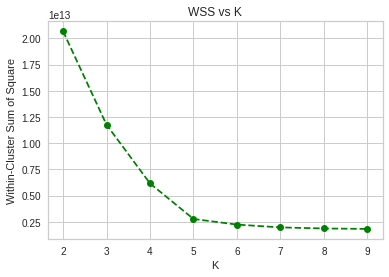

In [86]:
plt.plot(n_clusters, wss, linestyle='--', marker='o', color='green')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K')
plt.show()

Alternatively, it is possible to use the methods within the yellowbrick library

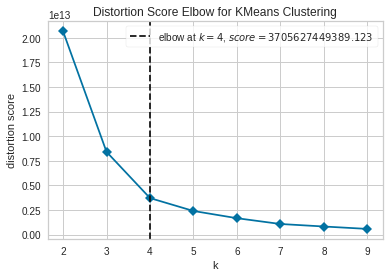

In [87]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=n_clusters, timings=False)
kmeans.fit(X)
kmeans.show()

### 7.1.2. Sillhouette score

In [88]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=n_clusters, timings=False, metric='silhouette')
kmeans.fit(X)
kmeans.show()

KeyboardInterrupt: 

# 8. Model training

# 9. Cluster analysis

# 10. Deploy to production